## House Prices 

 - [Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)
 - [學習](https://www.kaggle.com/code/shunsukeozeki/house-prices-regression-with-pytorch)
 - 我記得可以觀察資料和Col相關性
 - [tqdm](https://blog.csdn.net/qq_43391414/article/details/121981491)

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD, Adam
from torch.nn import RMSNorm
from torch import nn
import torch
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import KFold

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_data = pd.read_csv(r'D:\NCNU\深度學習實驗\w5\house-prices-advanced-regression-techniques\train.csv')
test_data = pd.read_csv(r'D:\NCNU\深度學習實驗\w5\house-prices-advanced-regression-techniques\test.csv')

## Feature Engineering

 - 看缺失值
 - `display()`
     - IPython的內置函數，它用於在Jupyter Notebook環境中顯示Python 物件的圖形化表示或其他格式化輸出

In [ ]:
pd.options.display.max_rows = 90
df_train_null = pd.DataFrame(train_data.isnull().sum(), columns=['Null Counts'])
df_test_null = pd.DataFrame(test_data.isnull().sum(), columns=['Null Counts'])
print('Training Data')
display(df_train_null[df_train_null['Null Counts'] != 0])
print('Test Data')
display(df_test_null[df_test_null['Null Counts'] != 0])

Training Data


,Null Counts
LotFrontage,259
Alley,1369
MasVnrType,872
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


Test Data


,Null Counts
MSZoning,4
LotFrontage,227
Alley,1352
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,894
MasVnrArea,15
BsmtQual,44
BsmtCond,45


 - Correlation

In [ ]:
pd.options.display.max_columns = 50
df_dtype = pd.DataFrame(train_data.dtypes, columns=['dtype'])
df_corr = train_data[df_dtype[df_dtype['dtype'] != 'object'].index].corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)
display(df_corr)
# 會顯示所有的
# df_corr = train_data[df_dtype[df_dtype['dtype'] != 'object'].index].corr().sort_values(by='SalePrice', ascending=False)
# display(df_corr.style.background_gradient(axis=None))

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


 - Feature engineering
     - [解說](https://www.kaggle.com/code/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda)

In [ ]:
# Features used to modeling
usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
                , 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'
                ,'LotFrontage','WoodDeckSF','OpenPorchSF'
                ,'ExterQual','KitchenQual','Neighborhood','MSZoning'
                ,'Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition']
df_train_usefull = train_data[usefull_cols].copy()
df_test_usefull = test_data[usefull_cols].copy()

In [ ]:
df_train_usefull.dtypes

OverallQual        int64
GrLivArea          int64
GarageArea         int64
TotalBsmtSF        int64
FullBath           int64
YearBuilt          int64
YearRemodAdd       int64
Fireplaces         int64
LotFrontage      float64
WoodDeckSF         int64
OpenPorchSF        int64
ExterQual         object
KitchenQual       object
Neighborhood      object
MSZoning          object
Alley             object
LotShape          object
LandContour       object
Condition1        object
HouseStyle        object
MasVnrType        object
SaleCondition     object
dtype: object

In [ ]:
# Null Count
df_train_usefull_null = pd.DataFrame(df_train_usefull.isnull().sum(), columns=['Null'])
display(df_train_usefull_null[df_train_usefull_null != 0].dropna())

df_test_usefull_null = pd.DataFrame(df_test_usefull.isnull().sum(), columns=['Null'])
display(df_train_usefull_null[df_test_usefull_null != 0].dropna())

,Null
LotFrontage,259.0
Alley,1369.0
MasVnrType,872.0


,Null
GarageArea,0.0
TotalBsmtSF,0.0
LotFrontage,259.0
KitchenQual,0.0
MSZoning,0.0
Alley,1369.0
MasVnrType,872.0


In [ ]:
# 填充
# 這邊注意是用 Training Data 去填充 Testing Data
df_test_usefull['GarageArea'] = df_test_usefull['GarageArea'].fillna(df_train_usefull['GarageArea'].mean())
df_test_usefull['TotalBsmtSF'] = df_test_usefull['TotalBsmtSF'].fillna(df_train_usefull['TotalBsmtSF'].mean())

# 其他的是補零
df_train_usefull['LotFrontage'] = df_train_usefull['LotFrontage'].fillna(0)
df_test_usefull['LotFrontage'] = df_test_usefull['LotFrontage'].fillna(0)
df_test_usefull['KitchenQual'] = df_test_usefull['KitchenQual'].fillna('TA')

In [ ]:
# yeo-johnson
for col in ['GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF']:
    PT = PowerTransformer(method='yeo-johnson')
    PT.fit(df_train_usefull[[col]].values)
    df_train_usefull[col] = PT.transform(df_train_usefull[[col]].values)
    df_test_usefull[col] = PT.transform(df_test_usefull[[col]].values)

# Standard
for col in ['TotalBsmtSF','LotFrontage']:
    SC = StandardScaler().fit(df_train_usefull[[col]].values)
    df_train_usefull[col] = SC.transform(df_train_usefull[[col]].values)
    df_test_usefull[col] = SC.transform(df_test_usefull[[col]].values)

 - `YearBuilt`
     - Original construction date
 - `YearRemodAdd`
     - Remodel date

In [ ]:
# Create YearRemodAdd -  YearBuilt flag columns
df_test_usefull['YearRemodAdd - YearBuilt'] = df_test_usefull['YearRemodAdd'] - df_test_usefull['YearBuilt']
df_train_usefull['YearRemodAdd - YearBuilt'] = df_train_usefull['YearRemodAdd'] - df_train_usefull['YearBuilt']

# Drop YearRemodAdd
df_train_usefull = df_train_usefull.drop(columns=['YearRemodAdd'])
df_test_usefull = df_test_usefull.drop(columns=['YearRemodAdd'])

 - `df_test_usefull['LotFrontage']`
     - Series(一維)
     - 適合做數值計算或對單一欄位操作
 - `df_test_usefull[['LotFrontage']]`
     - DataFrame(二維)
     - 適合後續當作表格處理，或一次選擇多個欄位

In [ ]:
# One Hot
need_ont_hot = ['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition']
df_train_usefull = pd.get_dummies(
    df_train_usefull,
    columns=need_ont_hot
)
df_test_usefull = pd.get_dummies(
    df_test_usefull,
    columns=need_ont_hot
)

 - `ExterQual` Evaluates the quality of the material on the exterior 
     - `Ex` Excellent
     - `Gd` Good
     - `TA` Average/Typical
     - `Fa` Fair
     - `Po` Poor
 - `KitchenQual` Kitchen quality
     - same as ExterQual

 - Downcasting behavior in `replace` is deprecated
     - 加上 `infer_objects(copy=False)` 來保留舊行為：
 - `.map`
     - 只影響單行，不影響整個DataFrame

In [ ]:
# Ordinal vals
for col in ['ExterQual', 'KitchenQual']:
    df_train_usefull[col] = df_train_usefull[col].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).infer_objects(copy=False)
    df_test_usefull[col] = df_test_usefull[col].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).infer_objects(copy=False)


C:\Users\wendy\AppData\Local\Temp\ipykernel_29748\1047619113.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_usefull[col] = df_train_usefull[col].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).infer_objects(copy=False)
C:\Users\wendy\AppData\Local\Temp\ipykernel_29748\1047619113.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test_usefull[col] = df_test_usefull[col].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).infer_objects(copy=False)


In [ ]:
# 檢查
# print(df_train_usefull.select_dtypes(include=['object'])) # 看object
# print(df_train_usefull.isna().sum().sum())  # 總共多少 NaN
# print(df_train_usefull.applymap(type).nunique())  # 檢查每欄是否有不同型別 # 1 -> OK # 2 -> 有兩種type

# print(df_train_usefull.dtypes)  # 檢查 DataFrame 


In [ ]:
# Transform DataFrame to ndarray
X_train = df_train_usefull.drop(columns='HouseStyle_2.5Fin').to_numpy().astype(np.float32)
y_train = train_data[['SalePrice']].to_numpy()
X_test = df_test_usefull.to_numpy().astype(np.float32)

# ndarray to Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

## Build Model

In [ ]:
print(X_train.shape)
print(X_test.shape)

torch.Size([1460, 78])
torch.Size([1459, 78])


 - Mean Squared Log Error (MSLE)
     - $\text{MSLE}=\frac1N\sum^N_i(\log_e(1+y_i)-\log_e(1+\hat y_i))^2$
 - `torch.log1p(x)`
     - 得到log(1+x)

In [ ]:
class Module(nn.Module):
    def __init__(self, input_dim):
        super(Module, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(16, 1)
        )
    def forward(self, X):
        return self.net(X)

In [ ]:
# Hyper-parameter
epochs = 500
batch_size = 32
k = 5

In [ ]:
kf = KFold(n_splits=k, shuffle=True)

In [ ]:
# 因為要用K-Fold，所以先不弄train_loader
# train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_test, batch_size=1)

In [ ]:
model = Module(X_train.shape[1]).to(device)
loss = nn.L1Loss()
optimizer = Adam(model.parameters(), weight_decay=1e-4)
history = {'loss':[], 'val_loss':[]}
model_path = './model/'
lowest_rmse = 1e9

In [ ]:
from torchsummary import summary
summary(model, (X_train.shape[-1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 48]           3,792
              ReLU-2                   [-1, 48]               0
           Dropout-3                   [-1, 48]               0
            Linear-4                   [-1, 32]           1,568
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                   [-1, 16]             528
              ReLU-8                   [-1, 16]               0
           Dropout-9                   [-1, 16]               0
           Linear-10                    [-1, 1]              17
Total params: 5,905
Trainable params: 5,905
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total

In [ ]:
if not os.path.exists(model_path): os.mkdir(model_path)

for i in range(epochs):
    training_loss = 0
    val_loss = 0
    model.train()
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
        X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]
        train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size)
        
        model.train()
        for data in train_loader:        
            optimizer.zero_grad()
            frame, label = data
            frame, label = frame.to(device), label.to(device)
            
            output = model(frame)
            output_loss = torch.sqrt(loss(output, label))
            training_loss += output_loss.item()
            
            # BP
            output_loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            for data in val_loader:
                frame, label = data
                frame, label = frame.to(device), label.to(device)
                
                output = model(frame)
                output_loss = torch.sqrt(loss(output, label))
                val_loss += output_loss.item()
                
    rmse = training_loss / len(train_loader) / k
    val_rmse = val_loss / len(val_loader) / k
    history['loss'].append(rmse)
    history['val_loss'].append(val_rmse)
    print(f'Epoch\t{i + 1}\tRMSE: {rmse: .4f}, Val RMSE: {val_rmse:.4f}')
    
    # Store Model
    if val_rmse < lowest_rmse:
        lowest_rmse = val_rmse
        torch.save(model, os.path.join(model_path, 'model.pt'))
        print('\033[33mSave\033[0m')
    

Epoch	1	RMSE:  391.9108, Val RMSE: 364.8548
Save
Epoch	2	RMSE:  279.8881, Val RMSE: 232.1379
Save
Epoch	3	RMSE:  276.9976, Val RMSE: 232.1472
Epoch	4	RMSE:  274.6025, Val RMSE: 229.1144
Save
Epoch	5	RMSE:  273.1487, Val RMSE: 227.4874
Save
Epoch	6	RMSE:  273.0971, Val RMSE: 228.6163
Epoch	7	RMSE:  272.3832, Val RMSE: 231.0419
Epoch	8	RMSE:  271.3387, Val RMSE: 228.5181
Epoch	9	RMSE:  269.4846, Val RMSE: 227.2398
Save
Epoch	10	RMSE:  268.8243, Val RMSE: 226.0451
Save
Epoch	11	RMSE:  271.0748, Val RMSE: 226.5091
Epoch	12	RMSE:  272.3794, Val RMSE: 224.9553
Save
Epoch	13	RMSE:  269.7709, Val RMSE: 222.7534
Save
Epoch	14	RMSE:  267.9139, Val RMSE: 222.2947
Save
Epoch	15	RMSE:  269.0470, Val RMSE: 221.6022
Save
Epoch	16	RMSE:  266.6980, Val RMSE: 224.9250
Epoch	17	RMSE:  269.5570, Val RMSE: 222.5199
Epoch	18	RMSE:  267.5986, Val RMSE: 221.0692
Save
Epoch	19	RMSE:  268.0864, Val RMSE: 218.7372
Save
Epoch	20	RMSE:  265.7417, Val RMSE: 218.5873
Save
Epoch	21	RMSE:  267.8178, Val RMSE: 219.0015

RMSE Loss 138.5504


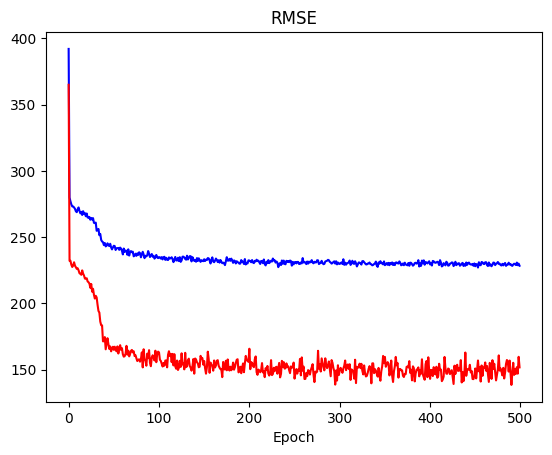

In [ ]:
print(f'RMSE Loss {min(history["val_loss"]):.4f}')

plt.cla(); plt.clf()
plt.plot(history['loss'], 'b', label='train')
plt.plot(history['val_loss'], 'r', label='validation')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.show()

In [ ]:
for frame in df_train_usefull.columns:
    if frame not in df_test_usefull.columns: print(frame)

HouseStyle_2.5Fin


In [ ]:
submit = 'Id,SalePrice\n'
idx = 1461
model = torch.load(os.path.join(model_path, 'model.pt'))
with torch.no_grad():
    model.eval()
    for data in test_loader:
        frame = data.to(device)
        output = model(frame)
        submit += f'{idx},{output.item()}\n'
        idx += 1

open('submit.csv', 'w').write(submit)
print('complete')

C:\Users\wendy\AppData\Local\Temp\ipykernel_29748\3354521204.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(model_path, 'model.pt'))


complete


In [ ]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime(r'%Y_%m_%d__%H_%M_%S')
print(now)

2025_03_23__22_02_29
